In [22]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import matplotlib.pyplot as plt 
from datetime import datetime

sns.set_theme()

In [95]:
native_kwok_df.columns

Index(['before_create_timestamp', 'before_firstwait_timestamp',
       'before_delete_timestamp', 'before_secondwait_timestamp',
       'before_cooldown_timestamp', 'before_join_timestamp', 'replicas',
       'framework', 'error_occured', 'errors_rised', 'step', 'total_steps',
       'cool_period', 'driver', 'command', 'event_created_at',
       'event_deleted_at', 'event_modified_at', 'event_replicas_at',
       'api_server_creation_delta', 'api_server_deletion_delta',
       'api_server_creation_delta_ms', 'api_server_deletion_delta_ms',
       'deployment_delta', 'deployment_delta_ms'],
      dtype='object')

In [106]:
def read_feather(filename):
    dataframe = pd.read_feather(filename)
    
    dataframe["api_server_creation_delta_ms"] = dataframe.api_server_creation_delta.map(lambda x: x.microseconds / 1000)
    dataframe["api_server_deletion_delta_ms"] = dataframe.api_server_deletion_delta.map(lambda x: x.microseconds / 1000)

    dataframe["deployment_delta"] = dataframe.event_deleted_at - dataframe.event_created_at
    dataframe["deployment_delta_ms"] = dataframe.deployment_delta.map(lambda x: x.microseconds / 1000)

    return dataframe

native_kwok_df = read_feather("./saved_experiments/native_kwok_20230228_010850.feather")
native_minikube_df = read_feather("./saved_experiments/native_minikube_20230228_011357.feather")

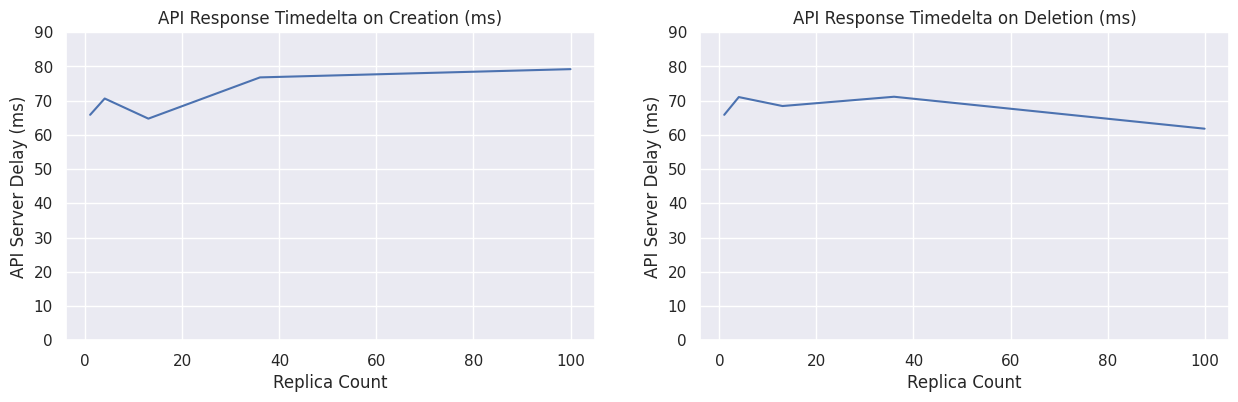

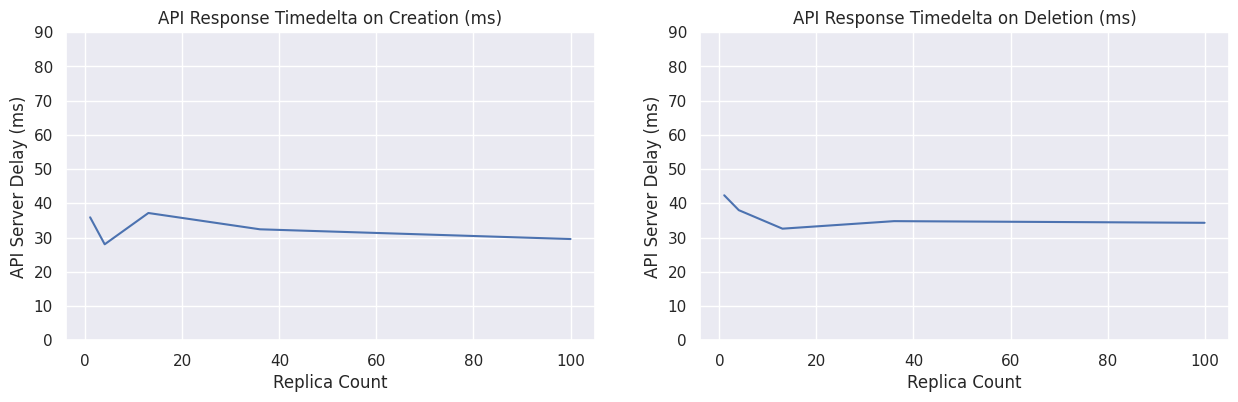

In [107]:
def draw_api_deltas_ms(dataframe: pd.DataFrame):
    means = dataframe.groupby(["replicas"]).mean(numeric_only=True)
    # max_delay = max(*means.api_server_creation_delta_ms, *means.api_server_deletion_delta_ms) + 10
    max_delay = 90 # Override

    api_server_creation_delta_ms = means.api_server_creation_delta_ms
    api_server_deletion_delta_ms = means.api_server_deletion_delta_ms

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(means.index, api_server_creation_delta_ms)
    plt.ylim(0, max_delay)
    plt.title("API Response Timedelta on Creation (ms)")
    plt.xlabel("Replica Count")
    plt.ylabel("API Server Delay (ms)")


    plt.subplot(1, 2, 2)
    plt.plot(means.index, api_server_deletion_delta_ms)
    plt.title("API Response Timedelta on Deletion (ms)")
    plt.ylim(0, max_delay)
    plt.xlabel("Replica Count")
    plt.ylabel("API Server Delay (ms)")
    
    plt.show()

draw_api_deltas_ms(native_kwok_df)
draw_api_deltas_ms(native_minikube_df)

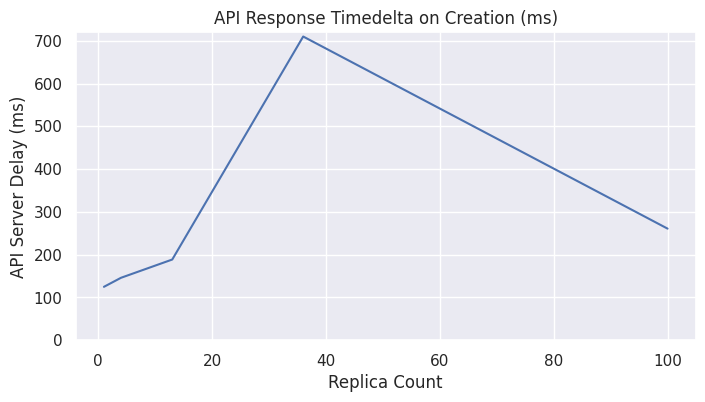

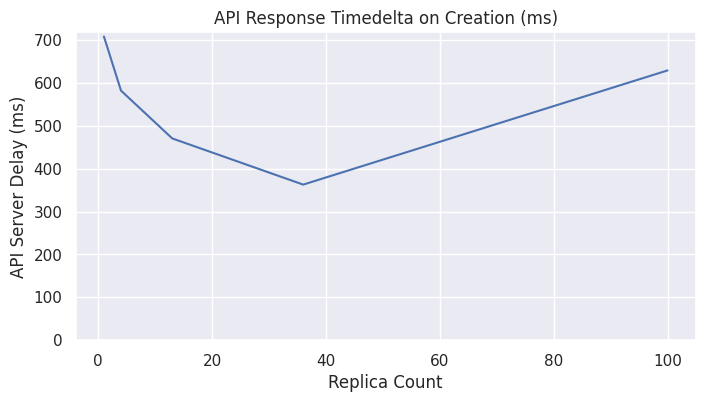

In [108]:
def draw_deployment_deltas_ms(dataframe: pd.DataFrame):
    means = dataframe.groupby(["replicas"]).mean(numeric_only=True)
    max_delay = max(*means.deployment_delta_ms) + 10
    # max_delay = 90 # Override

    plt.figure(figsize=(8, 4))
    # plt.subplot(1, 1, 1)
    plt.plot(means.index, means.deployment_delta_ms)
    plt.ylim(0, max_delay)
    plt.title("API Response Timedelta on Creation (ms)")
    plt.xlabel("Replica Count")
    plt.ylabel("API Server Delay (ms)")
    
    plt.show()

draw_deployment_deltas_ms(native_kwok_df)
draw_deployment_deltas_ms(native_minikube_df)